In [6]:
from deepmol.loaders import CSVLoader
import pandas as pd
import numpy as np

# Load data from CSV file
loader = CSVLoader(dataset_path='amostras_30000.csv',
                   smiles_field='smiles',
                   id_field='ids',
                   mode='auto')
# create the dataset
csv_dataset = loader.create_dataset(sep=',', header=0)

In [7]:
csv_dataset.get_shape()

2025-05-22 15:19:11,050 — INFO — Mols_shape: (30000,)
2025-05-22 15:19:11,053 — INFO — Features_shape: None
2025-05-22 15:19:11,054 — INFO — Labels_shape: None


((30000,), None, None)

In [ ]:
from tqdm import tqdm


def manhattan_similarity(x, y):
    """
    Compute Manhattan similarity between two vectors.
    Parameters:
        x, y : array-like
            Input vectors (must be the same length).
    Returns:
        float : Similarity score.
    """
    x = np.array(x)
    y = np.array(y)
 
    distance = np.sum(np.abs(x - y))
 
    return distance

def compute_all_similarities(dataset):
    """
    Compute all pairwise similarities in the dataset.
    Parameters:
        dataset : list of lists
            Each inner list represents a sample.
    Returns:
        list of tuples : Each tuple contains two indices and their similarity score.
    """
    fp = dataset.X.copy()
    
# Preallocate vector of correct size
    n_samples = fp.shape[0]
    n_comps = int((n_samples ** 2 - n_samples) / 2)
    similarity = np.zeros((1, n_comps,), dtype=np.float32)

    # Start pairwise similarity counter
    count = 0

    # Loop over all unique pairs (skip redundant comparisons)
    for i in tqdm(range(n_samples - 1), desc="Computing similarities"):
        for j in range(i + 1, n_samples):
            # Calculate similarity as 1 - Jaccard distance
            similarity[0, count] = manhattan_similarity(fp[i, :], fp[j, :])
            count += 1

    return similarity

def normalize_similarity_matrix(similarity_matrix):
    """
    Normalize the similarity matrix to a range of [0, 1].
    Parameters:
        similarity_matrix : numpy array
            The similarity matrix to normalize.
    Returns:
        numpy array : Normalized similarity matrix.
    """
    max_val = np.max(similarity_matrix)
 
    normalized_matrix = 1 - (similarity_matrix / max_val)
 
    return normalized_matrix

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle 


def generate_mst(similarities_matrix, labels):

    # Step 2: Convert the Correlation Matrix to a Distance Matrix
    distance_matrix = 1 - similarities_matrix

    # Create a graph from the distance matrix
    G = nx.Graph()
    num_nodes = distance_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G.add_edge(i, j, weight=distance_matrix[i, j])

    # Compute the minimum spanning tree without inversion
    mst_without_inversion = nx.minimum_spanning_tree(G)

    # Set the labels for the nodes in the graph
    for node in mst_without_inversion.nodes():
        if node in labels:
            mst_without_inversion.nodes[node]['label'] = labels[node]
        else:
            mst_without_inversion.nodes[node]['label'] = str(node)

    return mst_without_inversion

In [ ]:
def fingerprint_pipeline(dataset, fingerprints, labels, random_state=42):
    
    ''' 
dataset: 
fingerprints: lista de featurizes 
labels: dicionario com os métodos 
random_state: random seed 

'''
    # Importações 
    import numpy as np

    similarity_matrices = [] #Lista onde vamos guardar os vetores de similaridade
    i=0
    # Aplicar uma a uma asfingerprints ao dataset
    for featurizer in fingerprints:
        featurizer.featurize(dataset, inplace=True)
        dataset.to_csv(f"{featurizer.__class__.__name__}_fp.csv")

        # Seleciona aleatoriamente as moléculas a utilizar
        np.random.seed(random_state)

        similarities = compute_all_similarities(dataset) # Calcula todas as similaridades entre as moleculas 
        similarities = normalize_similarity_matrix(similarities) # Normaliza esses valores

        similarity_matrices.append(similarities) # Guarda as similaridades de cada método

    similarities = np.concatenate(similarity_matrices, axis=0) # Junta tudo numa matriz
        
    
    correlation_matrix = np.corrcoef(similarities) # Calcula a correlation entre os métodos de fingerprint, quão semelhantes são os vetores gerados por cada método
    with open("correlation_matrix.pkl","wb") as f:
    
        mst = generate_mst(similarities, labels) # Chama a função generate_mst que vai usar a correlation matrix para gerar a MST
    
    with open("similarities.pkl", "wb") as f:
        pickle.dump(similarities, f)


    

    

    return correlation_matrix, mst

In [11]:
from deepmol.compound_featurization import NPClassifierFP, BiosynfoniKeys, NeuralNPFP, MHFP, MorganFingerprint

cor_matrix, mst = fingerprint_pipeline(
    csv_dataset,                     # O dataset carregado com SMILES
    fingerprints=[NPClassifierFP(), BiosynfoniKeys(), NeuralNPFP(), MHFP(), MorganFingerprint()],
    labels={0: "NPClassifierFP",
            1: "BiosynfoniKeys",
            2: "NeuralNPFP",
            3: "MHFP", 
            4: "MorganFingerprint"
            }
)


/home/ppereira/miniforge3/envs/Project/lib/python3.11/site-packages/deepmol/compound_featurization/neural_npfp_generator.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

KeyboardInterrupt: 

In [2]:
from deepmol.loaders import CSVLoader
import pandas as pd
import numpy as np

# Load data from CSV file
loader = CSVLoader(dataset_path='amostras_30000.csv',
                   smiles_field='smiles',
                   id_field='ids',
                   mode='auto' ,
                   shard_size= 500
                   )
# create the dataset
csv_dataset = loader.create_dataset(sep=',', header=0)

import os
from deepmol.compound_featurization import LLM
from transformers import BertConfig, BertModel
 
from deepmol.tokenizers import NPBERTTokenizer
 
transformer = LLM(model_path="NPBERT", model=BertModel, config_class=BertConfig,
                          tokenizer=NPBERTTokenizer(vocab_file=os.path.join("NPBERT", "vocab.txt")), device="cuda:0")
transformer.featurize(csv_dataset, inplace=True)

Some weights of BertModel were not initialized from the model checkpoint at NPBERT/model.pt and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [00:06<00:00, 74.74it/s]


In [ ]:
# Draw the graphs
pos_without = nx.spring_layout(mst, weight='weight', k=1.0, iterations=300)

# Extract node labels
node_labels_without = nx.get_node_attributes(mst, 'label')

# Draw the graph without inversion
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
nx.draw(mst, pos_without, with_labels=True, labels=node_labels_without, node_color='lightblue', edge_color='gray')
edge_labels_without = nx.get_edge_attributes(mst, 'weight')
# nx.draw_networkx_edge_labels(mst, pos_without, edge_labels=edge_labels_without)
plt.title("Minimum Spanning Tree")

# Draw the graph with inversion

plt.show()

In [ ]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels={0: "NPClassifierFP",
            1: "BiosynfoniKeys",
            2: "NeuralNPFP",
            3: "MHFP", 
            4: "MorganFingerprint"
            }

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Similarity Measures')
plt.xlabel('Similarity Measures')
plt.ylabel('Similarity Measures')
plt.xticks(ticks=np.arange(5) + 0.5, labels=labels.values(), rotation=45)
plt.yticks(ticks=np.arange(5) + 0.5, labels=labels.values(), rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import pickle

In [5]:
with open("correlation_matrix.pkl", "rb") as f:
    correlation_matrix = pickle.load(f)


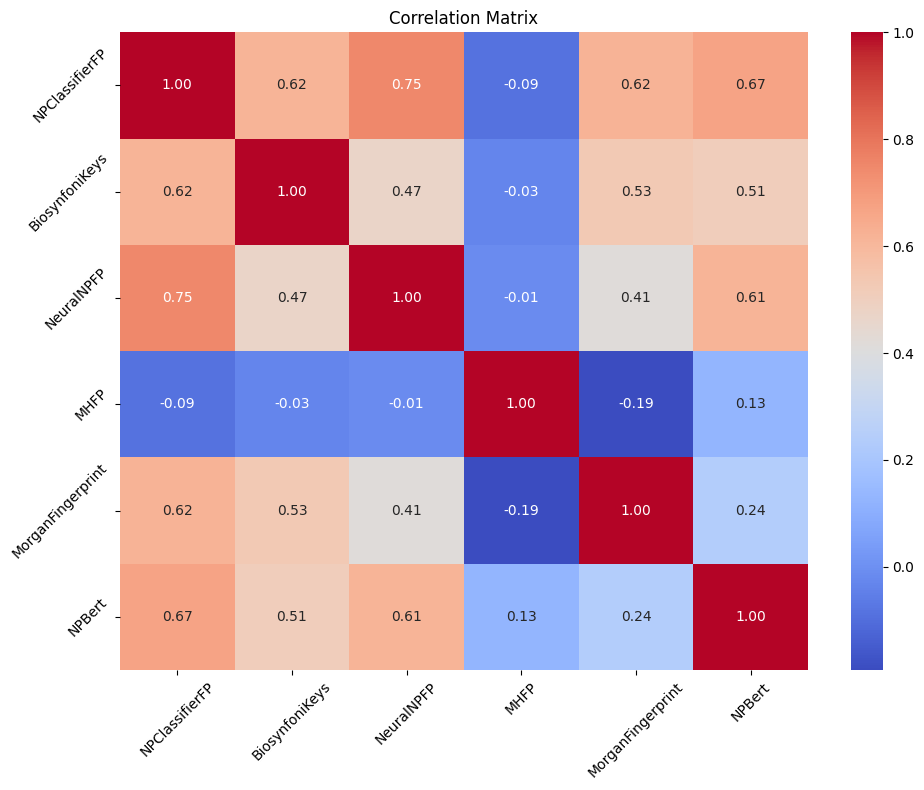

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Labels a aplicar
labels = {
    0: "NPClassifierFP",
    1: "BiosynfoniKeys",
    2: "NeuralNPFP",
    3: "MHFP", 
    4: "MorganFingerprint",
    5: "NPBert"
}

# Converter o ndarray para DataFrame com os labels como índices e colunas
df_corr = pd.DataFrame(correlation_matrix, index=labels.values(), columns=labels.values())

# Visualização
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



In [3]:
with open ("mst.pkl", "rb") as f:
    mst = pickle.load(f)

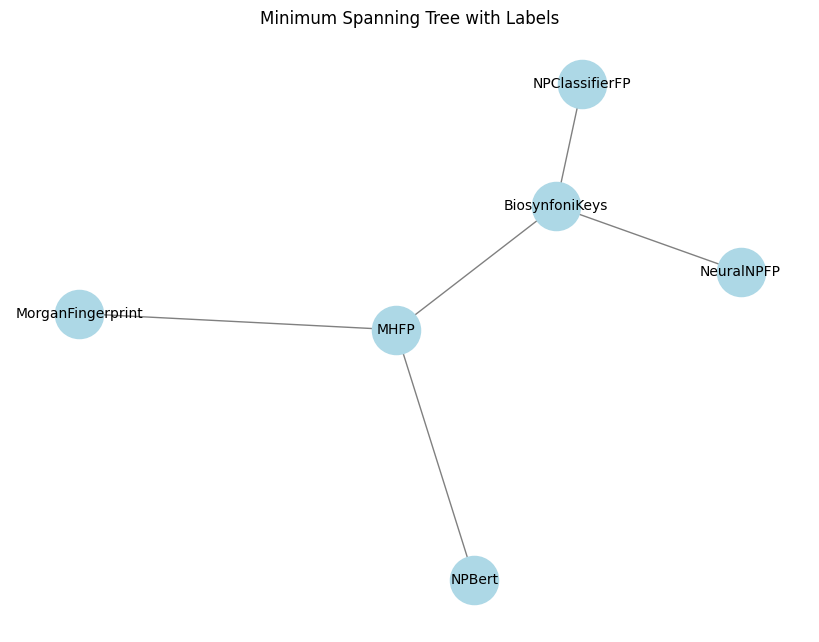

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Labels
labels = {
    0: "NPClassifierFP",
    1: "BiosynfoniKeys",
    2: "NeuralNPFP",
    3: "MHFP", 
    4: "MorganFingerprint",
    5: "NPBert"
}

# Relabel os nós do grafo
mst_labeled = nx.relabel_nodes(mst, labels)

# Visualizar grafo
plt.figure(figsize=(8, 6))
nx.draw(
    mst_labeled,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=1200,
    font_size=10
)
plt.title("Minimum Spanning Tree with Labels")
plt.show()



In [2]:
import pickle

with open("similarities.pkl", "rb") as f:
    similarities = pickle.load(f)


In [31]:
print(type(similarities))


<class 'numpy.ndarray'>


In [9]:
try:
    print(similarities.head())
except:
    print(similarities)


[[0.95666665 0.87777776 0.86444443 ... 0.95666665 0.92055553 0.95611113]
 [0.97936374 0.938951   0.94754946 ... 0.97248495 0.97248495 0.9828031 ]
 [0.9614376  0.63445795 0.6714988  ... 0.82993245 0.79234505 0.8898964 ]
 [0.9969775  0.97511506 0.9805485  ... 0.96271205 0.95961547 0.96160144]
 [0.9832215  0.8187919  0.761745   ... 0.9395973  0.8087248  0.82214767]
 [0.80260503 0.5906086  0.66591585 ... 0.6845143  0.6426227  0.65452266]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels para o eixo X
labels = [
    "NPClassifierFP",
    "BiosynfoniKeys",
    "NeuralNPFP",
    "MHFP", 
    "MorganFingerprint",
    "NPBert"
]

# Transpor se necessário
if similarities.shape[0] == 6:
    similarities = similarities.T  # Agora: (n_amostras, 6)

# Separar os dados por coluna
data = [similarities[:, i] for i in range(similarities.shape[1])]

# Criar o violin plot com matplotlib
plt.figure(figsize=(10, 6))
plt.violinplot(data, showmedians=True)
plt.xticks(ticks=np.arange(1, 7), labels=labels, rotation=45)
plt.title("Distribution of Similarity Scores by Fingerprint")
plt.ylabel("Similarity")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "NPClassifierFP",
    "BiosynfoniKeys",
    "NeuralNPFP",
    "MHFP", 
    "MorganFingerprint",
    "NPBert"
]

# Transpor se necessário
if similarities.shape[0] == 6:
    similarities = similarities.T

# Criar DataFrame temporário apenas para visualização
df_long = pd.DataFrame(similarities).melt(var_name='Fingerprint', value_name='Similarity')
df_long['Fingerprint'] = df_long['Fingerprint'].map(dict(enumerate(labels)))

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Fingerprint', y='Similarity', data=df_long, inner='quartile')
plt.xticks(rotation=45)
plt.title("Distribution of Similarity Scores by Fingerprint")
plt.tight_layout()
plt.show()


In [7]:
# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Fingerprint', y='Similarity', data=df_long, inner='quartile')
plt.xticks(rotation=45)
plt.title("Distribution of Similarity Scores by Fingerprint")
plt.tight_layout()
plt.show()

NameError: name 'df_long' is not defined

<Figure size 1000x600 with 0 Axes>

Importar os pickels da MST e da CM
    with open("correlation_matrix.pkl","rb") as f:
    pickle.load(correlation_matrix, f)

Violine plot / box plot com a distribuição da similaridade para cada fp com todas as comparações pair wise


FileNotFoundError: [Errno 2] No such file or directory: 'violinplot_similarity.png'

In [2]:
with open("similarities.pkl", "wb") as f:
    pickle.dump(similarities, f)


NameError: name 'similarities' is not defined